Original pixel values (stored in an array):
[[162 162 162 ... 170 155 128]
 [162 162 162 ... 170 155 128]
 [162 162 162 ... 170 155 128]
 ...
 [ 43  43  50 ... 104 100  98]
 [ 44  44  55 ... 104 105 108]
 [ 44  44  55 ... 104 105 108]]

Compression Ratio: 13.11


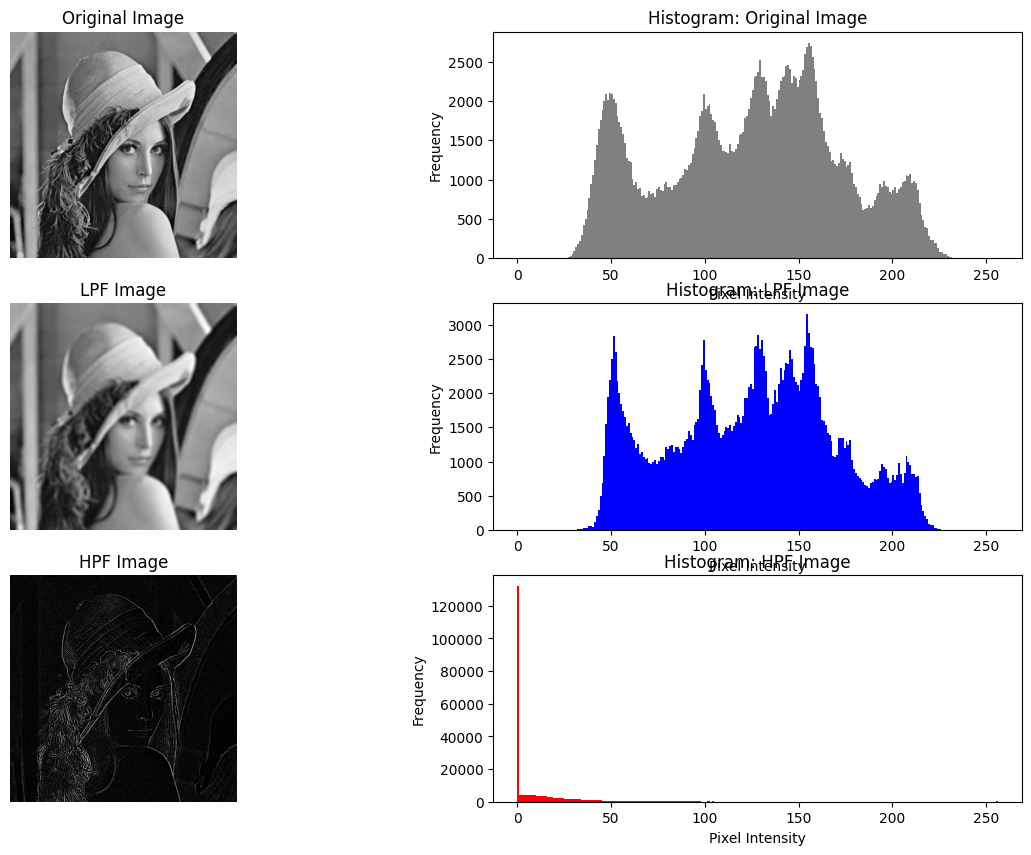

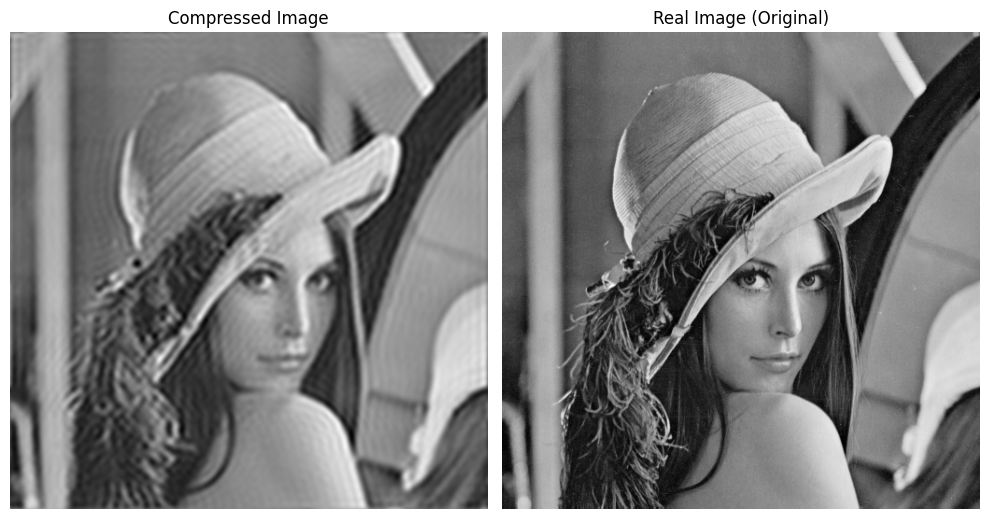

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path to the grayscale image
image_path = "standard_test_images/lena_gray_512.tif"

# Read the grayscale image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    print(f"Error: Unable to load image from {image_path}. Please check the path.")
else:
    # Display original pixel values
    print("Original pixel values (stored in an array):")
    original_pixel_values = np.array(image)
    print(original_pixel_values)

    # Apply Low Pass Filter (LPF)
    kernel_size = 9
    lpf_mask = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size ** 2)
    lpf_image = cv2.filter2D(image, -1, lpf_mask)

    # Apply High Pass Filter (HPF)
    hpf_kernel = np.array([[1, 1, 1],
                           [1, -8, 1],
                           [1, 1, 1]], dtype=np.float32)
    hpf_image = cv2.filter2D(image, -1, hpf_kernel)

    # Perform Discrete Fourier Transform (DFT)
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)

    # Magnitude Spectrum
    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shifted[:, :, 0], dft_shifted[:, :, 1]) + 1)

    # Retain only a portion of the frequencies (compression)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2  # Center
    radius = 50  # Radius of the retained region

    # Create a mask for compression
    mask = np.zeros((rows, cols, 2), np.uint8)
    mask[crow - radius:crow + radius, ccol - radius:ccol + radius] = 1

    # Apply the mask to the DFT
    compressed_dft = dft_shifted * mask

    # Inverse DFT to reconstruct the image
    compressed_dft_shifted = np.fft.ifftshift(compressed_dft)
    compressed_image = cv2.idft(compressed_dft_shifted)
    compressed_image = cv2.magnitude(compressed_image[:, :, 0], compressed_image[:, :, 1])

    # Normalize the compressed image for proper visualization
    compressed_image = cv2.normalize(compressed_image, None, 0, 255, cv2.NORM_MINMAX)

    # Compression ratio
    non_zero_original = np.count_nonzero(magnitude_spectrum)
    non_zero_compressed = np.count_nonzero(mask)
    compression_ratio = non_zero_original / non_zero_compressed

    print(f"\nCompression Ratio: {compression_ratio:.2f}")

    # Plot the results
    plt.figure(figsize=(15, 10))

    # Original Image and Histogram
    plt.subplot(3, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(3, 2, 2)
    plt.hist(image.ravel(), bins=256, range=[0, 256], color='gray')
    plt.title("Histogram: Original Image")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    # LPF Image and Histogram
    plt.subplot(3, 2, 3)
    plt.imshow(lpf_image, cmap='gray')
    plt.title("LPF Image")
    plt.axis("off")

    plt.subplot(3, 2, 4)
    plt.hist(lpf_image.ravel(), bins=256, range=[0, 256], color='blue')
    plt.title("Histogram: LPF Image")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    # HPF Image and Histogram
    plt.subplot(3, 2, 5)
    plt.imshow(hpf_image, cmap='gray')
    plt.title("HPF Image")
    plt.axis("off")

    plt.subplot(3, 2, 6)
    plt.hist(hpf_image.ravel(), bins=256, range=[0, 256], color='red')
    plt.title("Histogram: HPF Image")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    # Plot Compressed Image and Magnitude Spectrum
    plt.figure(figsize=(10, 8))

    # Compressed Image
    plt.subplot(1, 2, 1)
    plt.imshow(np.uint8(compressed_image), cmap='gray')
    plt.title("Compressed Image")
    plt.axis("off")

    # Magnitude Spectrum (Original)
    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray')
    plt.title("Real Image (Original)")
    plt.axis("off")

    # Show the plot
    plt.tight_layout()
    plt.show()
